In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 10: Stellargraph Data Import
StellarGraph model

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np

In [3]:
from pathlib import Path

In [7]:
!pip install chardet

  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [9]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    average_precision_score, roc_auc_score
from sklearn.inspection import permutation_importance
from scikitplot.metrics import plot_lift_curve
from sklearn.ensemble import GradientBoostingClassifier

ModuleNotFoundError: No module named 'scikitplot'

In [ ]:
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html

In [ ]:
https://gist.github.com/Orbifold/5e267774dcafa58e7e3cafce7e9c73b6

In [ ]:
https://stellargraph.readthedocs.io/en/stable/demos/node-classification/graphsage-node-classification.html

In [ ]:
https://stellargraph.readthedocs.io/en/v1.2.0/api.html
class stellargraph.StellarGrap

In [ ]:
Python 3.6 envt!

https://stackoverflow.com/questions/43759610/how-to-add-python-3-6-kernel-alongside-3-5-on-jupyter


# Vignette

https://stellargraph.readthedocs.io/en/stable/demos/node-classification/graphsage-node-classification.html

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

2023-11-14 22:09:38.343241: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-14 22:09:38.343267: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-14 22:09:38.343275: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-14 22:09:38.343589: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-14 22:09:38.343948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [4]:
set(node_subjects)

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [5]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

In [6]:
from collections import Counter

Counter(train_subjects)

Counter({'Neural_Networks': 81,
         'Rule_Learning': 18,
         'Theory': 35,
         'Genetic_Algorithms': 42,
         'Case_Based': 30,
         'Reinforcement_Learning': 22,
         'Probabilistic_Methods': 42})

In [7]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

In [8]:
batch_size = 50
num_samples = [10, 5]

In [9]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [10]:
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

In [11]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

In [15]:
#Added
import numpy as np
import tensorflow as tf
np.random.seed(16)
tf.random.set_seed(16)

In [16]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [26]:
x_inp

[<KerasTensor: shape=(None, 1, 1433) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 10, 1433) dtype=float32 (created by layer 'input_5')>,
 <KerasTensor: shape=(None, 50, 1433) dtype=float32 (created by layer 'input_6')>]

In [27]:
x_out

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'lambda')>

In [18]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

##### Got this warning
WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
WARNING:absl:`lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
##### And so changed the above

In [19]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [21]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20


2023-11-14 22:17:01.176039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 22:17:06.559190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 - 7s - loss: 1.8740 - acc: 0.2778 - val_loss: 1.7154 - val_acc: 0.3581 - 7s/epoch - 1s/step
Epoch 2/20
6/6 - 1s - loss: 1.6429 - acc: 0.4000 - val_loss: 1.5964 - val_acc: 0.4221 - 835ms/epoch - 139ms/step
Epoch 3/20
6/6 - 1s - loss: 1.4892 - acc: 0.5704 - val_loss: 1.4468 - val_acc: 0.5874 - 823ms/epoch - 137ms/step
Epoch 4/20
6/6 - 1s - loss: 1.3525 - acc: 0.7333 - val_loss: 1.3290 - val_acc: 0.7137 - 813ms/epoch - 136ms/step
Epoch 5/20
6/6 - 1s - loss: 1.2031 - acc: 0.8704 - val_loss: 1.2241 - val_acc: 0.7580 - 992ms/epoch - 165ms/step
Epoch 6/20
6/6 - 1s - loss: 1.0898 - acc: 0.9111 - val_loss: 1.1300 - val_acc: 0.7740 - 802ms/epoch - 134ms/step
Epoch 7/20
6/6 - 1s - loss: 0.9886 - acc: 0.9185 - val_loss: 1.0571 - val_acc: 0.7884 - 827ms/epoch - 138ms/step
Epoch 8/20
6/6 - 1s - loss: 0.8806 - acc: 0.9519 - val_loss: 0.9862 - val_acc: 0.7970 - 871ms/epoch - 145ms/step
Epoch 9/20
6/6 - 1s - loss: 0.7782 - acc: 0.9556 - val_loss: 0.9450 - val_acc: 0.7994 - 832ms/epoch - 139ms/step


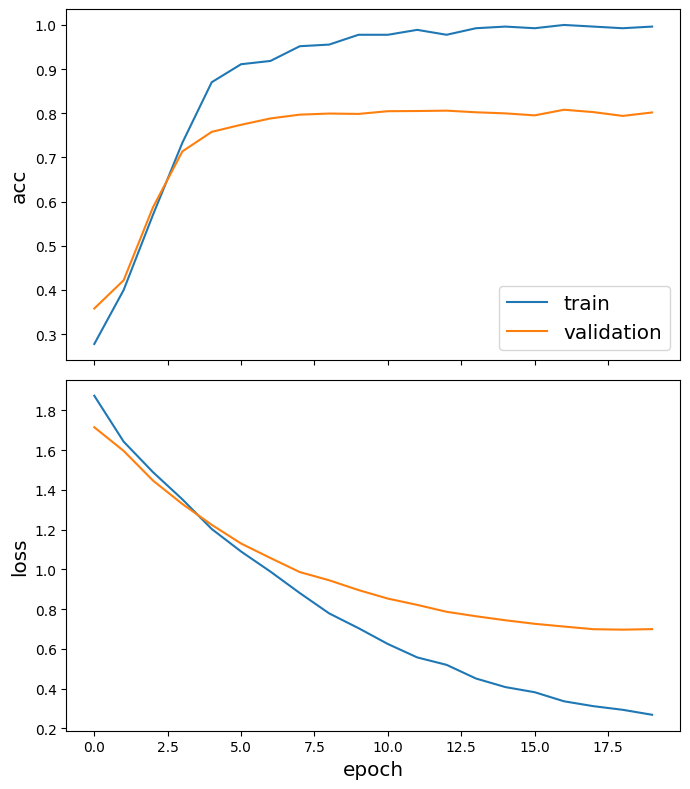

In [22]:
sg.utils.plot_history(history)

In [23]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

49/49 [==============================] - 1s 14ms/step - loss: 0.7007 - acc: 0.7994

Test Set Metrics:
	loss: 0.7007
	acc: 0.7994


I had trouble with the parts here, my flow needed 2 inputs including the targets..

In [56]:
index_list = [c for c in test_subjects.index] + [c for c in train_subjects.index]

In [57]:
all_targ = np.concatenate((test_targets, train_targets),axis=0)

In [58]:
all_gen = generator.flow(index_list, all_targ)

In [59]:
all_predictions = model.predict(all_gen)

55/55 [==============================] - 1s 12ms/step


In [60]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [65]:
np.concatenate((test_subjects.values, train_subjects.values))

array(['Reinforcement_Learning', 'Case_Based', 'Neural_Networks', ...,
       'Genetic_Algorithms', 'Genetic_Algorithms',
       'Reinforcement_Learning'], dtype=object)

In [66]:
df = pd.DataFrame({"Predicted": node_predictions, "True": np.concatenate((test_subjects.values, train_subjects.values))})
df.head(10)

,Predicted,True
0,Reinforcement_Learning,Reinforcement_Learning
1,Reinforcement_Learning,Case_Based
2,Neural_Networks,Neural_Networks
3,Genetic_Algorithms,Genetic_Algorithms
4,Neural_Networks,Neural_Networks
5,Neural_Networks,Neural_Networks
6,Neural_Networks,Neural_Networks
7,Probabilistic_Methods,Probabilistic_Methods
8,Genetic_Algorithms,Genetic_Algorithms
9,Neural_Networks,Neural_Networks
